<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/TimesFM/Fine_tune_TimesFM_on_a_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune TimesFM on a custom dataset

In this notebook, we will show that one could fine-tune Google's [TimesFM](https://huggingface.co/docs/transformers/model_doc/timesfm) (Time Series Foundation Model) on a custom dataset of time-series, besides just making zero-shot predictions. This means that we are going to update the weights of the model.

## Set-up environment

Let's start by installing 🤗 Transformers as well as [PEFT](https://huggingface.co/docs/peft/en/index), which will allow for Parameter-Efficient Fine-Tuning. Make sure to set "runtime" to "GPU" for faster computation.

In [ ]:
!pip install -q --upgrade transformers peft

# Load dataset

Let's load a dataset which hopefully is out-of-distribution for this model, consisting of some Internet-of-Things (IoT) style data which measures requests per second:

In [ ]:
import requests
import zipfile
import io
import os
from glob import glob
from tqdm import tqdm
import pandas as pd

# URL of the zip file
zip_url = "https://sir-dataset.obs.cn-east-3.myhuaweicloud.com/datasets/public_dataset/public_dataset.zip"

# Directory to extract the files
extract_dir = "public_dataset_extracted"

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Download the zip file
print(f"Downloading {zip_url}...")
response = requests.get(zip_url)
response.raise_for_status() # Raise an exception for bad status codes

# Extract the zip file
print("Extracting the zip file...")
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall(extract_dir)
print("Extraction complete.")

# Path to the requests_minute directory
requests_minute_dir = os.path.join(extract_dir, "public_dataset", "csv_files", "requests_minute")
filenames_list = glob(requests_minute_dir + '/*.csv')
filenames_list.sort()

# Reading all columns in all per-minute requests files may take up signficant memory
dfs_list = []
for filename in tqdm(filenames_list):
    # read the entire file, or read just the columns we want by passing usecols = ['time', 'day', 0, 1, 2] to pd.read_csv()
    df_i = pd.read_csv(filename, index_col=None)
    dfs_list.append(df_i)
print('Concatenating dataframes')
df_requests = pd.concat(dfs_list)
df_requests

Extracting the zip file...
Extraction complete.


100%|██████████| 26/26 [00:32<00:00,  1.24s/it]


Concatenating dataframes


,day,time,0,1,2,3,4,5,6,7,...,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092
0,0,0,NaN,NaN,NaN,6772,5996,NaN,1361,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,60,NaN,NaN,NaN,7244,6511,NaN,1551,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,120,NaN,NaN,NaN,5990,5412,NaN,1289,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,180,NaN,NaN,NaN,5742,5227,NaN,1285,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,240,NaN,NaN,NaN,4844,4377,NaN,1466,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,25,2246100,NaN,NaN,2.0,2308,790,NaN,3212,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1436,25,2246160,NaN,NaN,NaN,2701,918,NaN,3075,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1437,25,2246220,NaN,NaN,NaN,2891,1003,NaN,2752,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1438,25,2246280,NaN,NaN,NaN,2827,968,NaN,2836,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The first 2 columns contain the date information (day and time), whereas all other columns contain individual time series, measuring different things.

Let's plot the time series of the 3rd column:

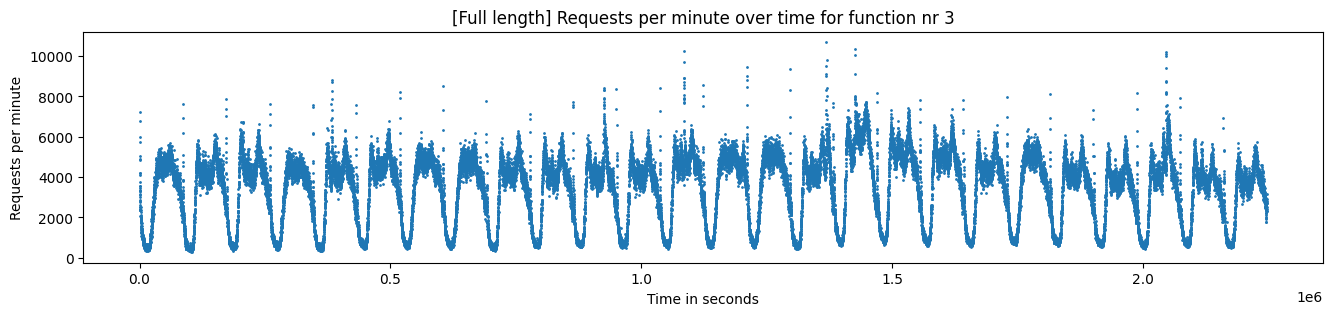

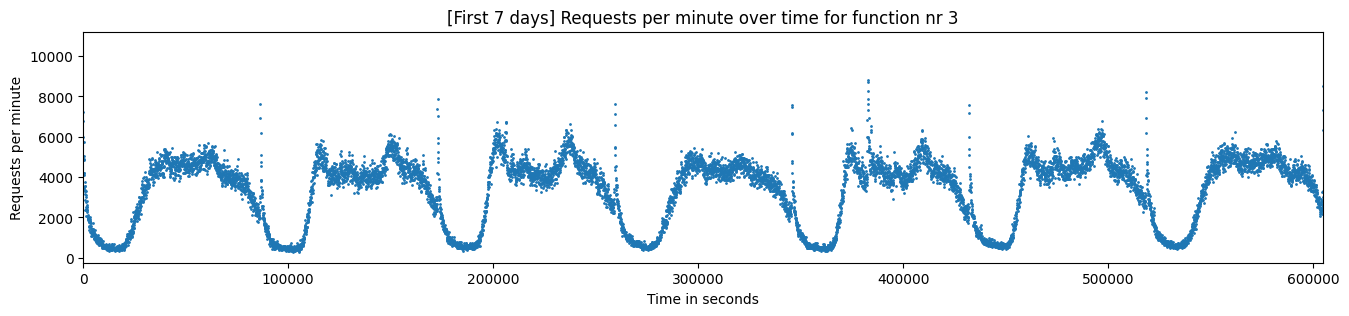

In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(16, 3))

plt.scatter(df_requests['time'], df_requests['3'], s=1)
plt.xlabel('Time in seconds')
plt.ylabel('Requests per minute')
plt.title('[Full length] Requests per minute over time for function nr 3')
plt.show()

n_days = 7
fig = plt.figure(figsize=(16, 3))
plt.scatter(df_requests['time'], df_requests['3'], s=1)
plt.xlabel('Time in seconds')
plt.ylabel('Requests per minute')
plt.title('[First {} days] Requests per minute over time for function nr 3'.format(n_days))
plt.xlim(0, 86400*n_days)
plt.show()

## Load model

Next we load the pre-trained TimesFM model, released by Google, from the 🤗 hub.

We also specify some additional parameters, namely:
- load the model in bfloat16 precision (this reduces the memory usage)
- use the ["sdpa"](https://docs.pytorch.org/tutorials/intermediate/scaled_dot_product_attention_tutorial.html) version of attention, for faster attention computation
- put it on the GPU, if available.

In [ ]:
import torch
from transformers import TimesFmModelForPrediction

model = TimesFmModelForPrediction.from_pretrained(
    "google/timesfm-2.0-500m-pytorch",
    attn_implementation="sdpa",
    device_map="cuda" if torch.cuda.is_available() else None
)

## Perform zero-shot forecasting

Before starting to fine-tune (updating the weights), we can test out the performance of the model out-of-the-box. Given TimesFM has been pre-trained on millions of time-series, it should already do a decent job.

For that we can perform a single forward pass through the model.

In [ ]:
# take the first time series of the dataset
time_series = df_requests['3']

In [ ]:
# use the default context and horizon length of the model
context_length = model.config.context_length
horizon_length = model.config.horizon_length

In [ ]:
context_values = time_series[-context_length + horizon_length:]

In [ ]:
ground_truth = time_series[-horizon_length:]

In [ ]:
past_values = torch.tensor(context_values.values).unsqueeze(0).to(device=model.device)

We also specify the frequency indicator, which in this case is 0, givne the data is per minute (refer to the [README of TimesFM](https://github.com/google-research/timesfm) for more details).

In [ ]:
frequency_id = [[0]]

In [ ]:
# forward pass
with torch.inference_mode():
  outputs = model(past_values=past_values, freq=frequency_id)

Let's plot the model's mean predictions alongside the ground truth data:

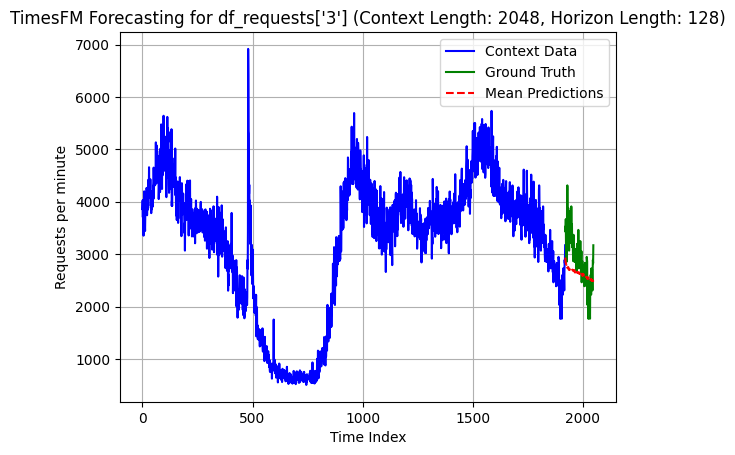

In [ ]:
context_indices = range(0, context_length-horizon_length)
plt.plot(context_indices, context_values, label='Context Data', color='blue')

# Plot the ground truth data
ground_truth_indices = range(context_length-horizon_length, context_length)
plt.plot(ground_truth_indices, ground_truth, label='Ground Truth', color='green')

# Plot the predicted values
predicted_indices = range(context_length-horizon_length, context_length)
plt.plot(predicted_indices, outputs.mean_predictions[0].cpu(), label='Mean Predictions', color='red', linestyle='--')

plt.xlabel('Time Index')
plt.ylabel('Requests per minute')
plt.title(f'TimesFM Forecasting for df_requests[\'3\'] (Context Length: {context_length}, Horizon Length: {horizon_length})')
plt.legend()
plt.grid(True)
plt.show()

## Create PyTorch dataset

Next, let's create a [custom PyTorch dataset](https://docs.pytorch.org/tutorials/beginner/data_loading_tutorial.html?highlight=dataset). For that we need to implement 3 methods:
- an init method, which initializes the dataset by setting some variables
- a length method, which returns the length of the dataset
- a getitem method, which returns one item of the dataset.

In [ ]:
from torch.utils.data import Dataset

class TimeSeriesRandomDataset(Dataset):
    def __init__(self, time_series, context_length, horizon_length):
        """
        Args:
            time_series (numpy.ndarray or pandas.Series): The time series data.
            context_length (int): The length of the context window.
            horizon_length (int): The length of the horizon window (ground truth).
        """
        if isinstance(time_series, pd.Series):
            self.time_series = time_series.dropna().values
        else:
            self.time_series = time_series
            if not isinstance(self.time_series, np.ndarray):
                self.time_series = np.array(self.time_series)

        self.context_length = context_length
        self.horizon_length = horizon_length
        self.total_window_length = context_length + horizon_length

        # The range of possible starting indices for a window
        # A window of total_window_length must fit within the time series
        self.max_start_index = len(self.time_series) - self.total_window_length

        if self.max_start_index < 0:
            raise ValueError(f"Time series is too short for the specified context ({context_length}) and horizon ({horizon_length}) lengths.")

        # We can define an arbitrary number of "epochs" or iterations per actual data point
        # For random sampling, the number of samples can be larger than the number of possible distinct windows
        self.num_samples = 1000 # You can adjust this number based on your desired dataset size

    def __len__(self):
        return self.num_samples # Return the predefined number of samples

    def __getitem__(self, idx):
        """
        Returns a random sample containing the context window and the subsequent horizon window.

        Args:
            idx (int): The index (ignored in random sampling, but required by Dataset).

        Returns:
            dict: A dictionary containing:
                'context': The context window (numpy.ndarray).
                'ground_truth': The subsequent horizon window (numpy.ndarray).
        """
        # Generate a random starting index within the valid range
        start_index = np.random.randint(0, self.max_start_index + 1)

        end_index = start_index + self.total_window_length

        window = self.time_series[start_index:end_index]

        context = window[:self.context_length]
        ground_truth = window[self.context_length:]

        return {'context': context, 'ground_truth': ground_truth}

Let's instantiate the dataset and create a corresponding PyTorch Dataloader, which allows us to get batches of data.

Neural networks are typically trained on batches of data, using a variant of stochastic gradient descent (SGD). We will train with a batch size of 32.

In [ ]:
from torch.utils.data import DataLoader

# Create the dataset
time_series_random_dataset = TimeSeriesRandomDataset(time_series, context_length, horizon_length)

# Create the dataloader
# batch_size determines how many windows are returned in each batch
# `shuffle` is often set to `False` when the dataset itself is random
batch_size = 32
time_series_random_dataloader = DataLoader(time_series_random_dataset, batch_size=batch_size, shuffle=False) # shuffle=False here as sampling is random

## Train the model

Next we can train the model in native PyTorch. We apply [LoRa](https://huggingface.co/docs/peft/main/en/conceptual_guides/lora) here, which is an example of a Parameter-Efficient Fine-Tuning method. The idea of LoRa is to only train a couple of linear projection layers on top of the pre-trained base model. This means that we're not going to actually update the pre-trained weights of the TimesFM model: they are kept frozen. The only thing we're going to train are the additional linear layers (also called "adapters") on top of the model.

Thanks to this, the memory requirements are much lower, since we only need to load the optimizer states for those adapters, and only train those. This allows us to run quite large fine-tuning runs on consumer hardware, like an NVIDIA T4 GPU.

Of course, this is different from "full fine-tuning" (in which we would update all the weights of the model). If you have the memory for that, then feel free to do so.

In [ ]:
import numpy as np

from peft import LoraConfig, get_peft_model # Import PEFT components


# 1. Define PEFT Configuration (LoRA)
# You need to identify the linear layers in TimesFM that you want to apply LoRA to.
# This often involves inspecting the model's architecture.
# Common targets include attention projection layers (q, k, v, o) and feed-forward layers.
# Let's assume for demonstration that 'q_proj', 'k_proj', 'v_proj', 'o_proj' are the target modules.
# You might need to adjust this based on the actual layer names in TimesFM.
lora_config = LoraConfig(
    r=16, # LoRA attention dimension
    lora_alpha=16, # Alpha parameter for LoRA scaling
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"], # Target linear layers
    lora_dropout=0.1, # Dropout probability for LoRA layers
    bias="none", # Bias type
)

# 2. Get PEFT Model
# Wrap your base model with the PEFT configuration
peft_model = get_peft_model(model, lora_config)

# Print the number of trainable parameters (should be much smaller than the base model)
peft_model.print_trainable_parameters()

# 3. Define Optimizer and Scheduler
optimizer = torch.optim.AdamW(peft_model.parameters(), lr=5e-5)

# You can optionally add a learning rate scheduler
# from transformers import get_scheduler
# num_epochs = 3
# num_training_steps = num_epochs * len(time_series_random_dataloader)
# lr_scheduler = get_scheduler(
#     name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
# )

# 4. Training Loop
num_epochs = 50 # Define the number of training epochs

peft_model.train() # Set the model to training mode

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    progress_bar = tqdm(time_series_random_dataloader, desc="Training")

    for batch in progress_bar:
        # Move batch data to the device
        context_batch = batch['context'].to(device=peft_model.device, dtype=torch.bfloat16 if peft_model.config.torch_dtype == 'bfloat16' else torch.float32)
        ground_truth_batch = batch['ground_truth'].to(device=peft_model.device, dtype=torch.bfloat16 if peft_model.config.torch_dtype == 'bfloat16' else torch.float32)

        # Determine the frequency ID for the new dataset
        # Ensure the frequency ID batch matches the batch size
        # Let's assume frequency_id 5 for minutely data as an example (check TimesFM docs)
        frequency_id_batch = [[0]] * context_batch.shape[0]

        # Forward pass
        outputs = peft_model(
            past_values=context_batch,
            freq=frequency_id_batch,
            future_values=ground_truth_batch # Provide ground truth for loss calculation
        )

        # Get the loss
        loss = outputs.loss

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        # if lr_scheduler is not None:
        #     lr_scheduler.step()
        optimizer.zero_grad()

        # Update progress bar description
        progress_bar.set_postfix(loss=loss.item())

print("\nTraining finished.")

trainable params: 8,192,000 || all params: 507,020,960 || trainable%: 1.6157
Epoch 1/50


Training: 100%|██████████| 32/32 [00:45<00:00,  1.43s/it, loss=3.23e+5]


Epoch 2/50


Training: 100%|██████████| 32/32 [00:47<00:00,  1.48s/it, loss=1.3e+5]


Epoch 3/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=3.27e+5]


Epoch 4/50


Training: 100%|██████████| 32/32 [00:47<00:00,  1.47s/it, loss=1.01e+5]


Epoch 5/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=3.01e+5]


Epoch 6/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=1.32e+5]


Epoch 7/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=1.29e+5]


Epoch 8/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=1.67e+5]


Epoch 9/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=1.29e+5]


Epoch 10/50


Training: 100%|██████████| 32/32 [00:47<00:00,  1.47s/it, loss=1.4e+5]


Epoch 11/50


Training: 100%|██████████| 32/32 [00:47<00:00,  1.47s/it, loss=1.32e+5]


Epoch 12/50


Training: 100%|██████████| 32/32 [00:47<00:00,  1.47s/it, loss=1.15e+5]


Epoch 13/50


Training: 100%|██████████| 32/32 [00:47<00:00,  1.47s/it, loss=1.36e+5]


Epoch 14/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.47s/it, loss=9.53e+4]


Epoch 15/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.47s/it, loss=7.61e+4]


Epoch 16/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=1.09e+5]


Epoch 17/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=8.53e+4]


Epoch 18/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.47s/it, loss=8.5e+4]


Epoch 19/50


Training: 100%|██████████| 32/32 [00:47<00:00,  1.47s/it, loss=1.07e+5]


Epoch 20/50


Training: 100%|██████████| 32/32 [00:47<00:00,  1.47s/it, loss=1.01e+5]


Epoch 21/50


Training: 100%|██████████| 32/32 [00:47<00:00,  1.47s/it, loss=1.13e+5]


Epoch 22/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=1.23e+5]


Epoch 23/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=5.01e+4]


Epoch 24/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=1.04e+5]


Epoch 25/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=1.48e+5]


Epoch 26/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=7.37e+4]


Epoch 27/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=8.63e+4]


Epoch 28/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.47s/it, loss=8.66e+4]


Epoch 29/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.47s/it, loss=1.09e+5]


Epoch 30/50


Training: 100%|██████████| 32/32 [00:47<00:00,  1.47s/it, loss=82222.5]


Epoch 31/50


Training: 100%|██████████| 32/32 [00:47<00:00,  1.47s/it, loss=8.69e+4]


Epoch 32/50


Training: 100%|██████████| 32/32 [00:47<00:00,  1.47s/it, loss=8.22e+4]


Epoch 33/50


Training: 100%|██████████| 32/32 [00:47<00:00,  1.47s/it, loss=8.4e+4]


Epoch 34/50


Training: 100%|██████████| 32/32 [00:47<00:00,  1.47s/it, loss=9.43e+4]


Epoch 35/50


Training: 100%|██████████| 32/32 [00:47<00:00,  1.47s/it, loss=8.54e+4]


Epoch 36/50


Training: 100%|██████████| 32/32 [00:47<00:00,  1.47s/it, loss=1.11e+5]


Epoch 37/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.47s/it, loss=8.32e+4]


Epoch 38/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.47s/it, loss=4.89e+4]


Epoch 39/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=6.98e+4]


Epoch 40/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=7.94e+4]


Epoch 41/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=7.39e+4]


Epoch 42/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=6.33e+4]


Epoch 43/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=8e+4]


Epoch 44/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=1.01e+5]


Epoch 45/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=7.26e+4]


Epoch 46/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=7.4e+4]


Epoch 47/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=9.09e+4]


Epoch 48/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=8.25e+4]


Epoch 49/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=1.04e+5]


Epoch 50/50


Training: 100%|██████████| 32/32 [00:46<00:00,  1.46s/it, loss=8.59e+4]


Training finished.


## Inference

Once the model is trained, we can perform inference by performing a forward pass.

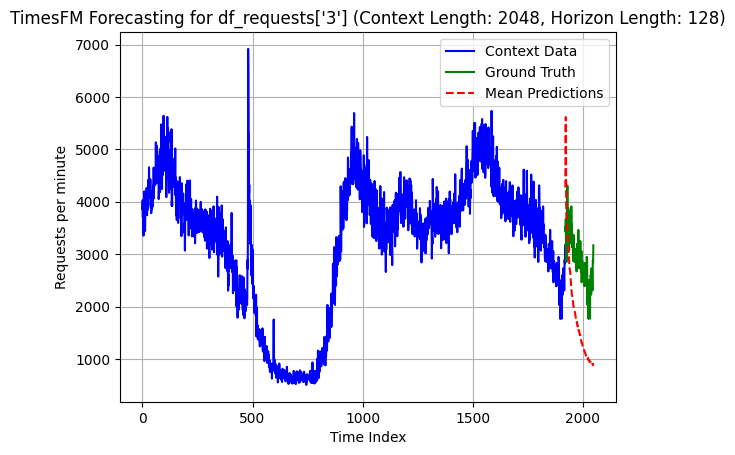

In [ ]:
from matplotlib import pyplot as plt


with torch.inference_mode():
  outputs = peft_model(past_values=past_values, freq=frequency_id)

context_indices = range(0, context_length-horizon_length)
plt.plot(context_indices, context_values, label='Context Data', color='blue')

# Plot the ground truth data
ground_truth_indices = range(context_length-horizon_length, context_length)
plt.plot(ground_truth_indices, ground_truth, label='Ground Truth', color='green')

# Plot the predicted values
predicted_indices = range(context_length-horizon_length, context_length)
plt.plot(predicted_indices, outputs.mean_predictions[0].cpu(), label='Mean Predictions', color='red', linestyle='--')

plt.xlabel('Time Index')
plt.ylabel('Requests per minute')
plt.title(f'TimesFM Forecasting for df_requests[\'3\'] (Context Length: {context_length}, Horizon Length: {horizon_length})')
plt.legend()
plt.grid(True)
plt.show()